# Backtest Trading Simulator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date
from src.markets import Market

from src.utils import market_plot, profit_and_portfolio_value, profits, portfolio_values, liquids, fees_and_tax, yields

### Simulation parameters

In [2]:
# Arguments
liquid = 100000                             # Initial liquid in USD
tickers = ['AAPL', 'GOOG', 'SPY', 'ORCL', 'TSLA', '^GSPC']   # The tickers of the stocks you would like to trade
periods = [2, 6, 30, 60]                         # Periods list for balancing in days
deposit = 1000
deposit_period = 30
ratios = [0.1, 0.1, 0.25, 0.25, 0.15, 0.15]           # The weight of each stock in the portfolio (adds up to 1)
sell_strategy = 'TAX_OPT'                      # ['LIFO', 'FIFO', 'TAX_OPT']
start_date = (2014, 1, 1)                   # Initial trading date tuple(yyyy, m, d)
end_date = (2018, 1, 1)                     # Final trading date tuple(yyyy, m, d)
buy_fee = 0.01                              # The fee you pay for a single buying transaction (%)
min_buy_fee = 2                             # The minimum ammount of buying fee in USD
sell_fee = 0.01                             # The fee you pay for a single selling transaction (%)
min_sell_fee = 2                            # The minimum ammount of selling fee in USD
tax = 25.                                   # The percentage of tax on selling in profit
verbose = False                             # Print to screen each balancing process [True, False]
plots_normalize = False                     # Normalize the market plot to starting date [True, False]

### Run

In [3]:
from src.main import simulator

# run the simulation
traders_list, market = simulator(
    liquid, tickers, periods, ratios, sell_strategy, start_date, end_date, buy_fee, 
    min_buy_fee, sell_fee, min_sell_fee, tax, verbose, plots_normalize, 
    deposit, deposit_period, show_plots=False, return_traders=True
)

period: 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


| Step:    100 /   1007 | Balance period:    2 |
| Step:    200 /   1007 | Balance period:    2 |
| Step:    300 /   1007 | Balance period:    2 |
| Step:    400 /   1007 | Balance period:    2 |
| Step:    500 /   1007 | Balance period:    2 |
| Step:    600 /   1007 | Balance period:    2 |
| Step:    700 /   1007 | Balance period:    2 |
| Step:    800 /   1007 | Balance period:    2 |
| Step:    900 /   1007 | Balance period:    2 |


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

| Step:   1000 /   1007 | Balance period:    2 |
period: 6


| Step:    100 /   1007 | Balance period:    6 |
| Step:    200 /   1007 | Balance period:    6 |
| Step:    300 /   1007 | Balance period:    6 |
| Step:    400 /   1007 | Balance period:    6 |
| Step:    500 /   1007 | Balance period:    6 |
| Step:    600 /   1007 | Balance period:    6 |
| Step:    700 /   1007 | Balance period:    6 |
| Step:    800 /   1007 | Balance period:    6 |


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

| Step:    900 /   1007 | Balance period:    6 |
| Step:   1000 /   1007 | Balance period:    6 |
period: 30


| Step:    100 /   1007 | Balance period:   30 |
| Step:    200 /   1007 | Balance period:   30 |
| Step:    300 /   1007 | Balance period:   30 |
| Step:    400 /   1007 | Balance period:   30 |
| Step:    500 /   1007 | Balance period:   30 |
| Step:    600 /   1007 | Balance period:   30 |
| Step:    700 /   1007 | Balance period:   30 |
| Step:    800 /   1007 | Balance period:   30 |


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

| Step:    900 /   1007 | Balance period:   30 |
| Step:   1000 /   1007 | Balance period:   30 |
period: 60


| Step:    100 /   1007 | Balance period:   60 |
| Step:    200 /   1007 | Balance period:   60 |
| Step:    300 /   1007 | Balance period:   60 |
| Step:    400 /   1007 | Balance period:   60 |
| Step:    500 /   1007 | Balance period:   60 |
| Step:    600 /   1007 | Balance period:   60 |
| Step:    700 /   1007 | Balance period:   60 |
| Step:    800 /   1007 | Balance period:   60 |
| Step:    900 /   1007 | Balance period:   60 |
| Step:   1000 /   1007 | Balance period:   60 |


In [4]:
def plot_index(market):
    index_return_percent = market.index_return_percent

    interval = int(len(market.index_return_percent) / 10)
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    ax.set_title('Market Index')
    ax.plot(market.index_data.index.to_numpy(), index_return_percent, label='S&P 500')
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('[%]')
    fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
    ax.grid()
    plt.show()


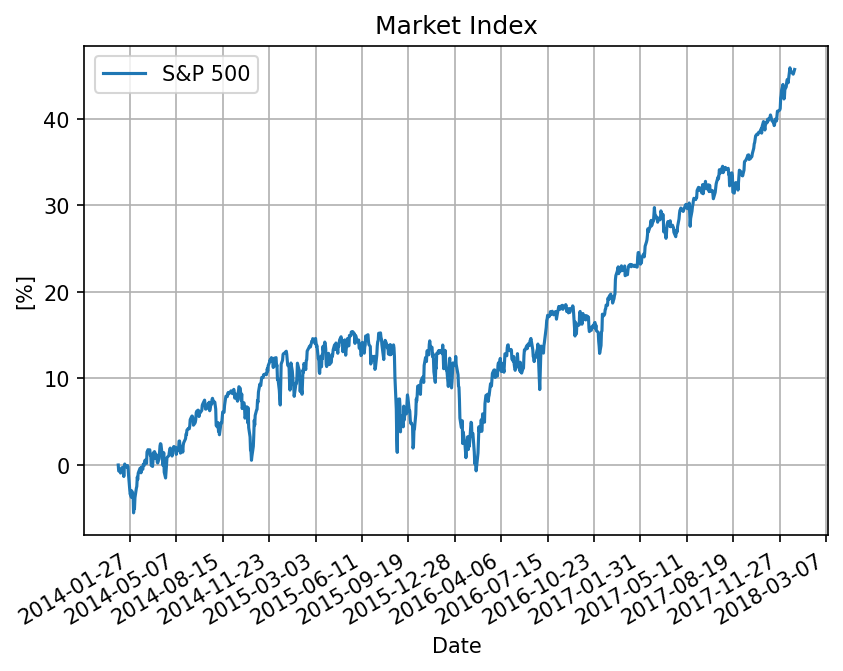

In [5]:
%matplotlib inline
plot_index(market)

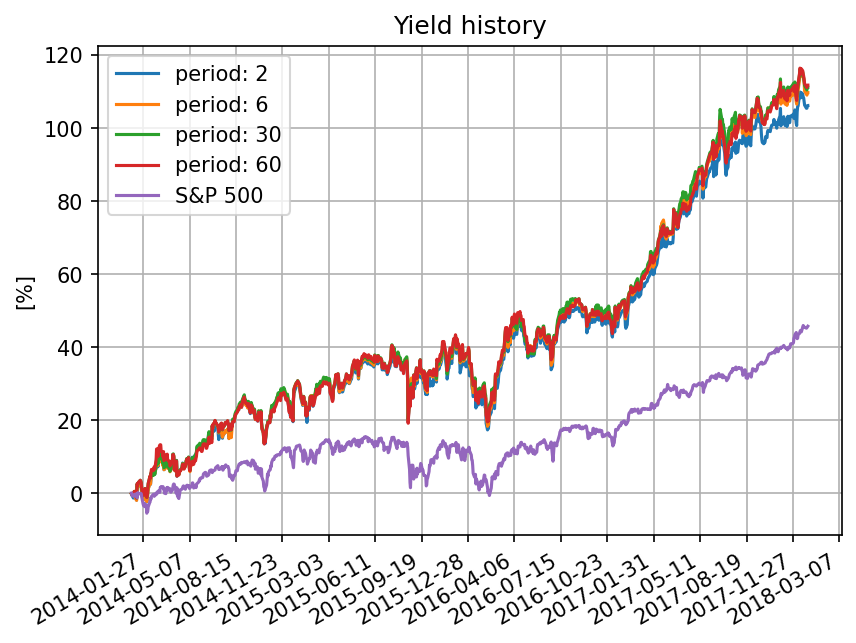

In [6]:
yields(traders_list, periods, 'period', market)

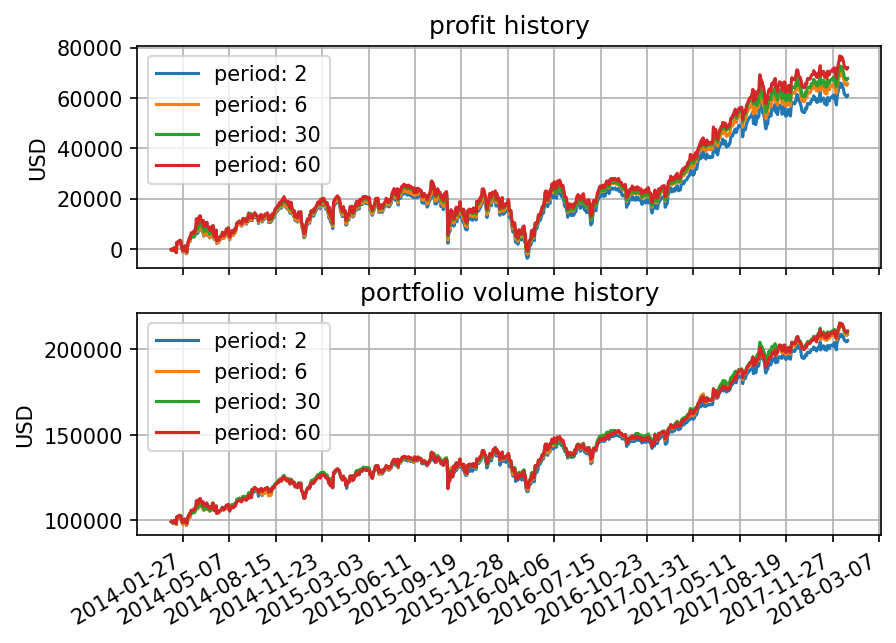

In [7]:
profit_and_portfolio_value(traders_list, periods, 'period')

In [8]:
def yields_usd(traders: list, parameter: list, parameter_name: str, market: Market):
    interval = int(len(traders[0].date_history) / 10)
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, dpi=150)
    axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    axes.set_title('Yield history')

    for i, trader in enumerate(traders):
        axes.plot(trader.date_history, trader.portfolio_value_history, label=parameter_name + ': ' + str(parameter[i]))

    axes.plot(market.index_data.index.to_numpy(), (market.index_return_percent / 100 + 1) * liquid, label='S&P 500')
    axes.set_ylabel('USD')
    fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
    axes.legend()
    axes.grid()
    plt.show()


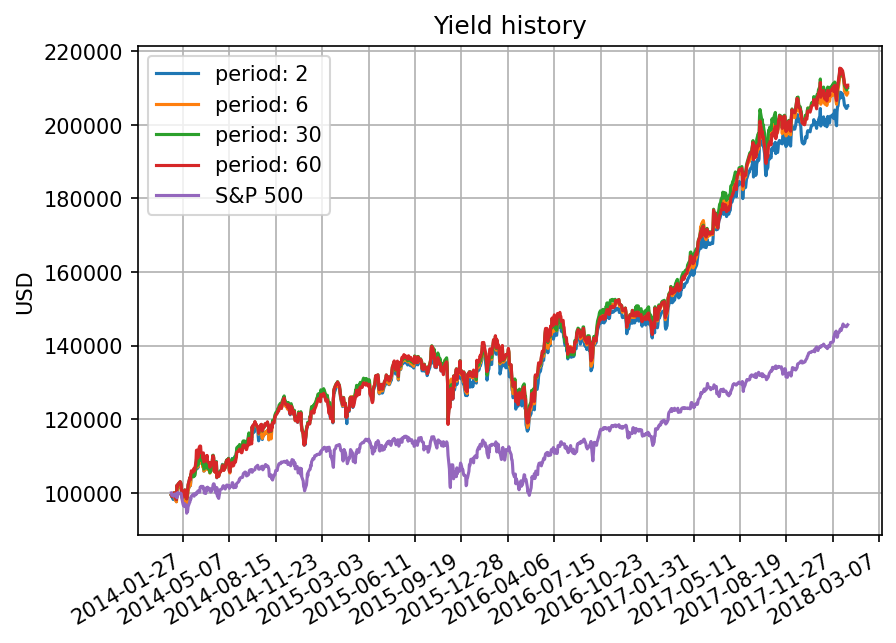

In [9]:
yields_usd(traders_list, periods, 'period', market)